Compilation Time :  0.005560874938964844
43/43 - 1s - loss: 0.0279 - val_loss: 0.0194 - 938ms/epoch - 22ms/step
Train Score: 41.87 RMSE
Test Score: 115.18 RMSE


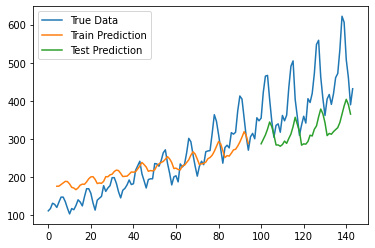

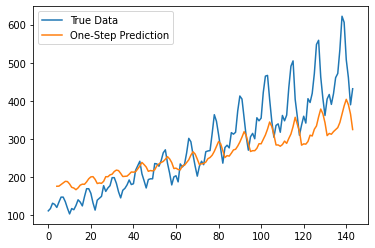

In [5]:

import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers.core import Dense 
from keras.models import Sequential

# We want to be able to repeat the experiment so we fix to a random seed
np.random.seed(70)

# Let us loading data 
data = pd.read_csv('international-airline-passengers.csv', usecols=[1])
data = data.dropna()  # Drop all Nans
data = data.values  # Convert from DataFrame to Python Array  
                    # You need to make sure the data is type of float
                    # you may use data = data.astype('float32') if your data are integers

# Prepare data .....

""" Scaling ...
Neural networks normally work well with scaled data, especially when we use
the sigmoid or tanh activation function. It is a good practice to scale the
data to the range of 0-to-1. This can be easily done by using scikit-learn's 
MinMaxScaler 
"""
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

"""  Splitting ...
We are going to use a time lag p = 3, so we will split the time series as
   x_1, x_2, x_3 x4 ->   x_5  [prediction]
   x_2, x_3, x_4  ->   x_5
   x_3, x_4, x_5  ->   x_6 
   ....
""" 
train_size = int(len(data)*0.67)   # Use the first 2/3 data for training
test_size = len(data) - train_size # the remaining for testing
Dtrain, Dtest = data[0:train_size,:], data[train_size:len(data),:]
# Both Xtrain and Xtest are in time series form, we need split them into sections
# in time-window size 4
time_lag = 4
Xtrain, Ytrain = [], []
for i in range(len(Dtrain) - time_lag -1):
    Xtrain.append(Dtrain[i:(i+time_lag), 0])   # pick up the section in time_window size
    Ytrain.append(Dtrain[i+time_lag, 0])       # pick up the next one as the prediction
Xtrain = np.array(Xtrain)    # Convert them from list to array   
Ytrain = np.array(Ytrain) 
 

Xtest, Ytest = [], []
for i in range(len(Dtest) - time_lag -1):
    Xtest.append(Dtest[i:(i+time_lag), 0])   # pick up the section in time_window size
    Ytest.append(Dtest[i+time_lag, 0])       # pick up the next one as the prediction
Xtest = np.array(Xtest)    # Convert them from list to array   
Ytest = np.array(Ytest) 

# Define our model .....
model = Sequential()
# Add a hidden layer with 20 neurons
model.add(Dense(100, input_dim=time_lag, activation='relu'))
# add the output layer, of course only one output node/neuron with no activation
model.add(Dense(1))

# Compiling model for use
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print("Compilation Time : ", time.time() - start)

# Training
model.fit(Xtrain, Ytrain, batch_size=2, verbose=2, validation_split=0.05)

# Predicting
# make predictions
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)
# invert predictions due to scaling
trainPredict = scaler.inverse_transform(trainPredict)
Ytrain = scaler.inverse_transform(Ytrain[:,np.newaxis])
testPredict = scaler.inverse_transform(testPredict)
Ytest = scaler.inverse_transform(Ytest[:,np.newaxis])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Ytrain, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Ytest, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Plotting results
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_lag:len(trainPredict)+time_lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_lag*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show()

# Overall Prediction with the train model
Xall = [] 
for i in range(len(data) - time_lag):
    Xall.append(data[i:(i+time_lag), 0])   # pick up the section in time_window size
Xall = np.array(Xall)    # Convert them from list to array  
allPredict = model.predict(Xall)
allPredict = scaler.inverse_transform(allPredict)
allPredictPlot = np.empty_like(data)
allPredictPlot[:, :] = np.nan
allPredictPlot[time_lag:, :] = allPredict

plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(allPredictPlot, label='One-Step Prediction') 
plt.legend()
plt.show()